This notebook shows how to build TFRecords from a custom image classification dataset and how to use the TFRecords to train a deep learning model in `tf.keras`. This notebook has some major sections:

- Writing TFRecords
- Loading in the TFRecords
- Applying data augmentation
- Model building
- Training models with TFRecords (w/ `fit_generator`)

Acknowledgements: [Martin Görner](https://twitter.com/martin_gorner) & [his amazing tutorial notebook](https://nbviewer.jupyter.org/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/keras_flowers_gputputpupod_tf2.1.ipynb).

## Notebook setup and imports

In [0]:
# Select TensorFlow 2.0 runtime
%tensorflow_version 2.x

In [0]:
# Imports
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pathlib
import re

In [3]:
print(tf.__version__)

2.0.0


## Flowers-17 dataset collection and a bit of inspection

In [4]:
# Get the flowers' dataset
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228818944/228813984 [==============================] - 4s 0us/step


In [5]:
# We have got five different classes
!ls {flowers}

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


In [0]:
# Don't change this
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

In [7]:
# There are a total of ____ images
total_data = len(list(paths.list_images(flowers)))
total_data

3670

## Helper functions for writing TFRecords

In [8]:
# Label extraction example
parts = tf.strings.split(b'/root/.keras/datasets/flower_photos/tulips/14087425312_2b5846b570_n.jpg', '/')
parts.numpy()[-2]

b'tulips'

In [0]:
# Function to read the image from the path,
# parse its labels, cast the pixel values to float,
# and resize the image
def parse_image(filename):
    parts = tf.strings.split(filename, '/')
    label = parts[-2]
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    return (image, label)

In [0]:
# `list_files` shuffles already
# AUTOTUNE makes it easier to make the parallelization dynamic
dataset = tf.data.Dataset.list_files(str(pathlib.Path(flowers)/'*/*'), seed=666)
dataset = dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [0]:
# Images are byte-strings
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

# Classes would be integers
def _int_feature(list_of_ints): 
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

In [0]:
# Function that prepares a record for the tfrecord file
# A record contains the image and its label
def to_tfrecord(img_bytes, label):  
    class_num = np.argmax(np.array(CLASSES)==label) 
    # print(class_num)
    feature = {
      "image": _bytestring_feature([img_bytes]), 
      "class": _int_feature([class_num]),             
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [0]:
# We need to convert the image to byte strings
# https://www.tensorflow.org/api_docs/python/tf/io/encode_jpeg
def recompress_image(image, label):
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return (image, label)

In [0]:
# Make full use of `map`
dataset = dataset.map(recompress_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(32) 

In [0]:
# Prepare tfrecords
for shard, (image, label) in enumerate(dataset):
    shard_size = image.numpy().shape[0]
    filename = "flowers-" + "{:02d}-{}.tfrec".format(shard, shard_size)
  
    with tf.io.TFRecordWriter(filename) as out_file:
        for i in range(shard_size):
            # print(label.numpy()[i])
            example = to_tfrecord(image.numpy()[i],label.numpy()[i])
            out_file.write(example.SerializeToString())
        print("Wrote file {} containing {} records".format(filename, shard_size))

## Reading TFRecords and applying data augmentation

In [0]:
# Function to read the TFRecords, segregate the images and labels
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  
    image = tf.reshape(image, [128, 128, 3]) 
    class_label = tf.cast(example['class'], tf.int32)
    
    return (image, class_label)

In [0]:
# A bit of data augmentation
def data_augment(image, class_label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return (image, class_label)

In [0]:
# Load the TFRecords and create tf.data.Dataset
def load_dataset(filenames):
    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=16) 
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset

In [0]:
# We need this to derive steps
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [0]:
# Batch, shuffle and repeat the dataset and pre-fetch it
# well before the current epoch ends
def batch_dataset(filenames, batch_size, train):
    dataset = load_dataset(filenames)
    n = count_data_items(filenames)
    
    if train:
        dataset = dataset.repeat()
        dataset = dataset.map(data_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.shuffle(1000)
    else:
        dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) 
    return (dataset, n//batch_size)

In [21]:
tfrecord_pattern = "*.tfrec"
filenames = tf.io.gfile.glob(tfrecord_pattern)
filenames[:10]

['./flowers-65-32.tfrec',
 './flowers-56-32.tfrec',
 './flowers-54-32.tfrec',
 './flowers-15-32.tfrec',
 './flowers-35-32.tfrec',
 './flowers-08-32.tfrec',
 './flowers-05-32.tfrec',
 './flowers-04-32.tfrec',
 './flowers-83-32.tfrec',
 './flowers-73-32.tfrec']

## Visual inspection

In [0]:
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
        
    return (numpy_images, numpy_labels)

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_from_dataset(dataset):
    subplot=331
    plt.figure(figsize=(13,13))
    images, labels = dataset_to_numpy_util(dataset, 9)
    for i, image in enumerate(images):
        title = CLASSES[labels[i]]
        subplot = display_one_flower(image, title, subplot)
        if i >= 8:
            break;

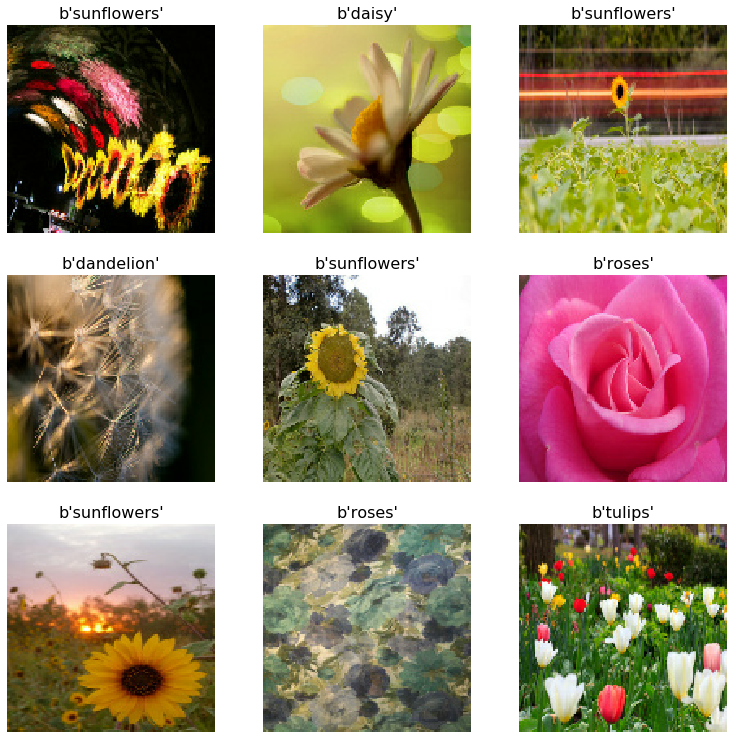

In [23]:
display_9_images_from_dataset(load_dataset(filenames))

## Model configs

In [24]:
BATCH_SIZE = 64

split = len(filenames) - int(len(filenames) * 0.2)
train_filenames = filenames[:split]
valid_filenames = filenames[split:]

training_dataset, steps_per_epoch = batch_dataset(train_filenames, BATCH_SIZE, True)
validation_dataset, validation_steps = batch_dataset(valid_filenames, BATCH_SIZE, False)

print("TRAINING   IMAGES: ", count_data_items(train_filenames), ", STEPS PER EPOCH: ", steps_per_epoch)
print("VALIDATION IMAGES: ", count_data_items(valid_filenames), ", STEPS PER EPOCH: ", validation_steps)

TRAINING   IMAGES:  2934 , STEPS PER EPOCH:  45
VALIDATION IMAGES:  736 , STEPS PER EPOCH:  11


## Model building and training

In [0]:
def get_training_model():
    baseModel = VGG16(weights="imagenet", include_top=False,
        input_tensor=Input(shape=(128, 128, 3)))

    headModel = baseModel.output
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(512, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(5, activation="softmax")(headModel)

    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    opt = SGD(lr=1e-4, momentum=0.9)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
        metrics=["accuracy"])
    return model

In [26]:
# With `fit_generator`
model = get_training_model()
model.fit_generator(training_dataset, 
         steps_per_epoch=steps_per_epoch,
         validation_data=validation_dataset,
         validation_steps=validation_steps,
         epochs=5)

58892288/58889256 [==============================] - 3s 0us/step
Epoch 1/5
45/45 [==============================] - 45s 992ms/step - loss: 1.8474 - accuracy: 0.2156 - val_loss: 1.5035 - val_accuracy: 0.3608
Epoch 2/5
45/45 [==============================] - 35s 780ms/step - loss: 1.5542 - accuracy: 0.3281 - val_loss: 1.3670 - val_accuracy: 0.4915
Epoch 3/5
45/45 [==============================] - 35s 781ms/step - loss: 1.4198 - accuracy: 0.4080 - val_loss: 1.2679 - val_accuracy: 0.5653
Epoch 4/5
45/45 [==============================] - 35s 782ms/step - loss: 1.3324 - accuracy: 0.4601 - val_loss: 1.2085 - val_accuracy: 0.5838
Epoch 5/5
45/45 [==============================] - 35s 781ms/step - loss: 1.2554 - accuracy: 0.5080 - val_loss: 1.1552 - val_accuracy: 0.5909


In [27]:
# With `fit`
model = get_training_model()
model.fit(training_dataset, 
         steps_per_epoch=steps_per_epoch,
         validation_data=validation_dataset,
         validation_steps=validation_steps,
         epochs=5)

Train for 45 steps, validate for 11 steps
Epoch 1/5
45/45 [==============================] - 12s 273ms/step - loss: 1.7840 - accuracy: 0.2295 - val_loss: 1.4535 - val_accuracy: 0.4276
Epoch 2/5
45/45 [==============================] - 10s 225ms/step - loss: 1.5400 - accuracy: 0.3271 - val_loss: 1.3202 - val_accuracy: 0.5653
Epoch 3/5
45/45 [==============================] - 10s 226ms/step - loss: 1.3708 - accuracy: 0.4424 - val_loss: 1.2316 - val_accuracy: 0.5994
Epoch 4/5
45/45 [==============================] - 10s 226ms/step - loss: 1.3126 - accuracy: 0.4872 - val_loss: 1.1816 - val_accuracy: 0.6051
Epoch 5/5
45/45 [==============================] - 10s 226ms/step - loss: 1.2745 - accuracy: 0.4990 - val_loss: 1.1316 - val_accuracy: 0.6378
